In [116]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from art.utils import load_mnist, preprocess

import os
import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

from tqdm import tqdm

import numdifftools as nd

In [117]:
TRAIN=False
COMPUTE_HESSIAN=True
RETRAIN=True
save_path = 'models/model.pt'
load_path = 'models/model.pt'

#### FL Fusion Class Selection

In [118]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [119]:
num_parties = 5
scale = 1
#Select the party that I would like to erase (ex: 3)
party_to_be_erased = 4

num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data
<a id='section_2'></a>

In [120]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Create Trainloader

In this Notebook we are going to create it by the following principle:
 - Each client will have 50% of it's dataset given by classes common among all the clients
 - Remaining 50% will be given to each client and will be different among different clients

Example:
client 3 will have 50% given by the labels: [0,1,2,3,4]. 50% will be with data coming just from the label [7]

In [121]:
all_indices = np.arange(len(y_train))
common_classes_indices = all_indices[np.sum(y_train*np.array([1,1,1,1,1,0,0,0,0,0]), axis = 1).astype(bool)]
list_clients_dataset_indices = np.split(common_classes_indices[:-(len(common_classes_indices)%5)], 5)

for i in range(5,10):
  label = [0,0,0,0,0,0,0,0,0,0]
  label[i] = 1
  indx = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
  list_clients_dataset_indices[i-5] = np.concatenate((list_clients_dataset_indices[i-5], indx[:len(indx)//5]))

x_train_ch = np.expand_dims(x_train, axis=1)
y_train_c = np.argmax(y_train, axis=1).astype(int)
trainloader_lst = []
for indices in list_clients_dataset_indices:
  ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
  trainloader_lst.append(DataLoader(ds, batch_size=128, shuffle=True))

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

In [122]:
trainloader_class_list = []
for i in range(10):
    label = [0,0,0,0,0,0,0,0,0,0]
    label[i] = 1
    indices = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
    ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
    trainloader_class_list.append(DataLoader(ds, batch_size=128, shuffle=True))

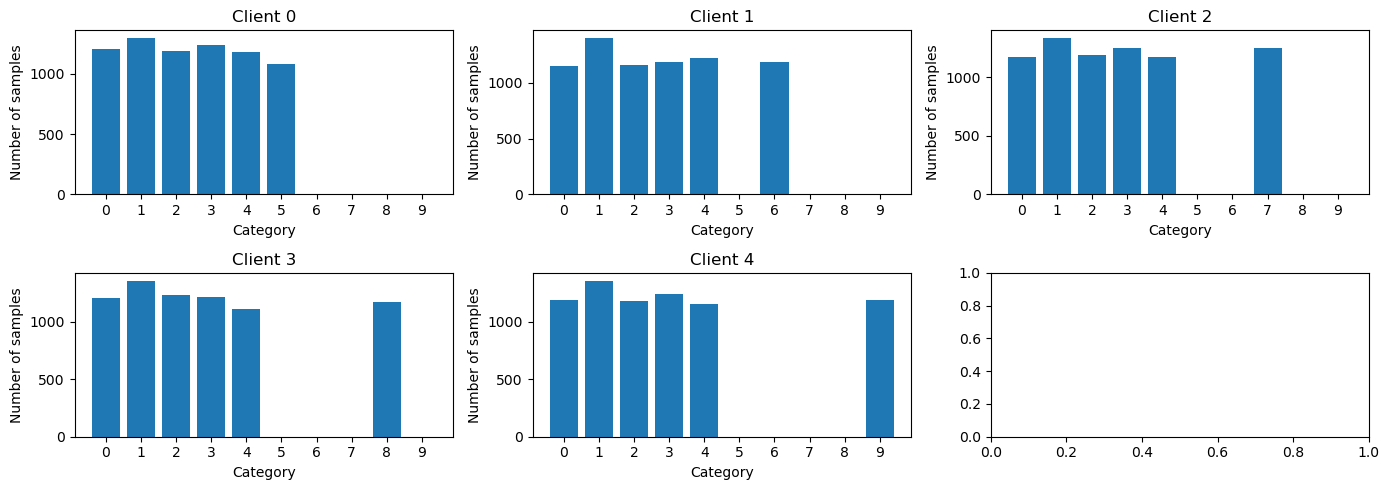

In [123]:
client_stats=[[]for i in range(5)]
for client in range(5):
    for category in range(10):
        client_indices=list_clients_dataset_indices[client]
        count=0
        for i in client_indices:
            if y_train_c[i]==category:
                count+=1
        client_stats[client].append(count)

axs = fig, axs = plt.subplots(2, 3, figsize=(14, 5))
for i,client in enumerate(client_stats):
    axs[i//3][i%3].bar(range(10),client)
    axs[i//3][i%3].set_title('Client '+str(i))
    axs[i//3][i%3].set_xticks(range(10))
    axs[i//3][i%3].set_xticklabels(range(10))
    axs[i//3][i%3].set_xlabel('Category')
    axs[i//3][i%3].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()


## 2. Train the FL Model
<a id='section_3'></a>

In [124]:
num_of_repeats = 1
num_fl_rounds = 50

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [125]:
class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [126]:
if TRAIN:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.cuda.empty_cache()
    party_models_dict = {}
    initial_model = FLNet2()
    model_dict = {}

    for fusion_key in fusion_types:
        model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

    for round_num in range(num_fl_rounds):
        local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

        for fusion_key in fusion_types:
            fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

            current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
            model = copy.deepcopy(initial_model)
            model.load_state_dict(current_model_state_dict)

            ##################### Local Training Round #############################
            party_models = []
            party_losses = []
            party_grad   = []        
            for party_id in range(num_parties):

                if fusion_key == 'Retrain':
                    break
                else:
                    model = copy.deepcopy(model).to(device)
                    model_update, party_loss = local_training.train(model=model,
                                                trainloader=trainloader_lst[party_id],
                                                device = device,
                                                criterion=None, opt=None)

                    party_models.append(copy.deepcopy(model_update.to('cpu')))
                    party_losses.append(party_loss)

                grad_norm = 0.0
                for param in model_update.parameters():
                    if param.grad is not None:
                        grad_norm += torch.norm(param.grad).cpu().item()
            
                party_grad.append(grad_norm)   
            
            grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

            loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
            ######################################################################

            current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

            model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
            party_models_dict[fusion_key] = party_models

            eval_model = FLNet2()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = Utils.evaluate(testloader, eval_model)
            clean_accuracy[fusion_key][round_num] = clean_acc
            print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

In [127]:
if TRAIN:
    def save_model_with_unique_name(model, base_path):
        # Split the base_path into the file name and extension
        base, ext = os.path.splitext(base_path)
        new_path = base_path
        counter = 1
        
        # Check if the file exists and update the filename if needed
        while os.path.exists(new_path):
            new_path = f"{base}({counter}){ext}"
            counter += 1

        torch.save(model.state_dict(), new_path)
        print(f"Model saved to {new_path}")

    eval_model = FLNet2()
    eval_model.load_state_dict(current_model_state_dict)
    save_model_with_unique_name(eval_model, save_path)

In [128]:
saved_model = FLNet2()
saved_model.load_state_dict(torch.load(load_path, weights_only=True))

<All keys matched successfully>

In [129]:
def create_dataloader(idx_client, _list_trainloader, percentage_to_remove):
    list_trainloader = copy.deepcopy(_list_trainloader)
    client_dataset = list_trainloader[idx_client].dataset

    num_samples_to_remove = int(len(client_dataset) * percentage_to_remove)
    num_samples_to_keep = len(client_dataset) - num_samples_to_remove
    
    if num_samples_to_keep != 0:
        new_dataset = TensorDataset(client_dataset[:num_samples_to_keep][0], client_dataset[:num_samples_to_keep][1])
        list_trainloader[idx_client] = DataLoader(new_dataset, batch_size=128)

    else:
        list_trainloader.pop(idx_client)

    return list_trainloader, num_samples_to_remove

In [130]:
from torch.utils.data import ConcatDataset

def analyze_removal(_model, _trainloader_list):
    remove_percentages = np.linspace(0, 1, 10)
    trainloader_list = copy.deepcopy(_trainloader_list)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = copy.deepcopy(_model).to(device)
    criterion = nn.CrossEntropyLoss()


    # Shuffle training datasets for each client only at the beginning
    # (this is done to avoid fictitious determinism in the results)
    training_datasets = [loader.dataset for loader in trainloader_list]
    shuffled_training_datasets = []
    for dataset in training_datasets:
        indices = np.random.permutation(len(dataset))
        shuffled_training_datasets.append(TensorDataset(dataset[indices][0], dataset[indices][1]))
    shuffled_trainloader_list = [DataLoader(dataset, batch_size=128) for dataset in shuffled_training_datasets]

    results = []

    for remove_percentage in remove_percentages:

        trainloader_list, _ = create_dataloader(party_to_be_erased, shuffled_trainloader_list, remove_percentage)
        
        client_dataset = ConcatDataset([loader.dataset for loader in trainloader_list])
        loader = DataLoader(client_dataset, batch_size=128)

        loss_sum = 0
        grad_sum = torch.zeros_like(torch.cat([param.flatten() for param in model.parameters()]))
        number_of_batches = 0

        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Sum quantities
            loss_sum += loss.cpu().item()
            grad_sum += torch.cat([param.grad.flatten() for param in model.parameters()])
            number_of_batches += 1
            
        grad_norm = torch.norm(grad_sum).cpu().item() / number_of_batches
        loss = loss_sum / number_of_batches

        
        # Store results
        results.append({
            'removal_percentage': remove_percentage,
            'gradient_norm': grad_norm,
            'loss': loss
        })
        
        print(f"Removal percentage: {remove_percentage:.2f}")
        print(f"  - Number of samples: {sum([len(loader.dataset) for loader in trainloader_list])}")
        print(f"  - Gradient norm: {grad_norm:.4f}")
        print(f"  - Loss: {loss:.4f}")
        print("-" * 50)

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Create plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot gradient norm vs Removal percentage
    axs[0].plot(results_df['removal_percentage'], results_df['gradient_norm'], 'o-')
    axs[0].set_title('Gradient Norm vs. Removal Percentage')
    axs[0].set_xlabel('Removal Percentage')
    axs[0].set_ylabel('Gradient Norm')
    axs[0].grid(True)

    # Plot loss vs Removal percentage
    axs[1].plot(results_df['removal_percentage'], results_df['loss'], 'o-')
    axs[1].set_title('Loss vs. Removal Percentage')
    axs[1].set_xlabel('Removal Percentage')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

#analyze_removal(saved_model, trainloader_lst)

In [131]:
from backpack import backpack, extend
from backpack.extensions import DiagHessian

trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

#Use the model if coming from the training or load if you have it downloaded
final_model = copy.deepcopy(saved_model)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.0001

# Create weights list
weights_unlearned = [1] * len(trainloader_list)
weights_unlearned[party_to_be_erased] = 1 - delta

weights_unlearned=torch.tensor(weights_unlearned, dtype=torch.float32)

weights_half = weights_unlearned
weights_half[party_to_be_erased] = 1 - delta / 2


Compute Hessians

In [132]:
def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h') and param.requires_grad:
            diag_hessian_params[name] = param.diag_h.clone().detach()
            # Cleanup to avoid leftover references
            del param.diag_h

    return diag_hessian_params


class AccumulatedDiagHessian:

    def __init__(self, model, criterion, device=None):
        self.model = model
        self.criterion = criterion
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')

        self.client_hessians = []  # Will store per-client Hessians

        # Will store final per-client Hessians after summing across that client's batches
        self.num_clients = 0
        self._computed = False

    def compute_client_hessians(self, dataloader_list):

        self.model = self.model.to(self.device)
        self.num_clients = len(dataloader_list)

        for loader_idx, loader in enumerate(dataloader_list):
            accumulated_diag_h = {}
            print(f"[Hessian] Calculating diagonal Hessian for client {loader_idx}...")
            
            for batch_idx, (inputs, targets) in enumerate(loader):
                # Compute the diag Hessian for this batch
                diag_h = compute_diag_hessian(self.model, self.criterion, inputs, targets, device=self.device)

                # Accumulate
                for name, value in diag_h.items():
                    if name not in accumulated_diag_h:
                        accumulated_diag_h[name] = value/len(loader)
                    else:
                        accumulated_diag_h[name] += value/len(loader)


            # Store the accumulated Hessian for this client
            self.client_hessians.append(accumulated_diag_h)

        self._computed = True

    def total_hessian(self):

        if not self._computed:
            raise RuntimeError("You must call `compute_client_hessians(...)` before requesting weights.")

        total_hessian = {}

        for name in self.client_hessians[0].keys():
            hess = sum(client_hessian[name] for client_hessian in self.client_hessians)/self.num_clients
            total_hessian[name] = hess.cpu().detach()
        
        return total_hessian
    
    
    def client_hessian_derivative(self, client_idx):

        if not self._computed:
            raise RuntimeError("You must call `compute_client_hessians(...)` before requesting weights.")
        
        hessian_derivative = {}

        for name in self.client_hessians[0].keys():
            hess = self.client_hessians[client_idx][name] / self.num_clients
            hessian_derivative[name] = hess.cpu().detach()
        return hessian_derivative
            

In [133]:
if COMPUTE_HESSIAN:
    hessian_calculator = AccumulatedDiagHessian(final_model, criterion)
    hessian_calculator.compute_client_hessians(trainloader_list)

[Hessian] Calculating diagonal Hessian for client 0...
[Hessian] Calculating diagonal Hessian for client 1...
[Hessian] Calculating diagonal Hessian for client 2...
[Hessian] Calculating diagonal Hessian for client 3...
[Hessian] Calculating diagonal Hessian for client 4...


In [134]:
if COMPUTE_HESSIAN:
    total_hessian = hessian_calculator.total_hessian()
    hessian_derivative = hessian_calculator.client_hessian_derivative(party_to_be_erased)

OUR METHOD

In [135]:
def continuos_information(total_hessian, hessian_derivative):
    information = []
    for k in total_hessian.keys():
        I = 0.5 * torch.pow(hessian_derivative[k]/total_hessian[k], 2)
        I[total_hessian[k] == 0] = 0
        information.append(I)
    return information

In [136]:
if COMPUTE_HESSIAN:  
    info_true = continuos_information(total_hessian, hessian_derivative)

In [137]:
if COMPUTE_HESSIAN:
    import pickle

    with open('cached/info_true.pkl', 'wb') as f:
        pickle.dump(info_true, f)

Load hessians

In [138]:
import pickle
with open('cached/info_true.pkl', 'rb') as f:
    info_true = pickle.load(f)

In [139]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

1517086
Number of outliers: 30342


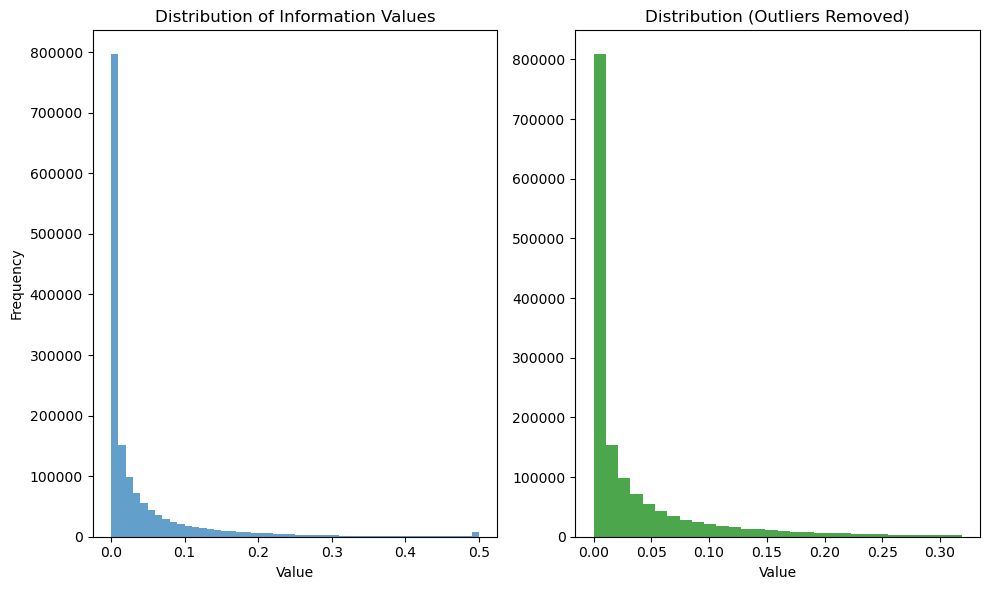

Sum of all information values: 62010.214844
Mean: 0.040874555706977844
Min: 1.401298464324817e-45
Max: 0.5
Total number of values: 1517086
Sum of all information values: 49095.425781
Mean: 0.03302210941910744
Min: 1.401298464324817e-45
Max: 0.31864726543426514
Total number of values: 1486744


(62010.21484375, 49095.42578125)

In [140]:
plot_information(info_true)

Helper Functions

In [141]:
import torchmetrics
import seaborn as sns

# create validation routine
def validate(net, dl, n_classes, device):
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=n_classes)
    # move metric to device
    net.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    net.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dl):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = net(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)


# Compute accuracy for each client
def compute_accuracy(model, testloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

def compute_accuracy_per_client(model, testloader_list):
    for i, testloader in enumerate(testloader_list):
        acc = compute_accuracy(model, testloader)
        print(f"Accuracy for class {i}: {acc:.2f}%")


Compute information

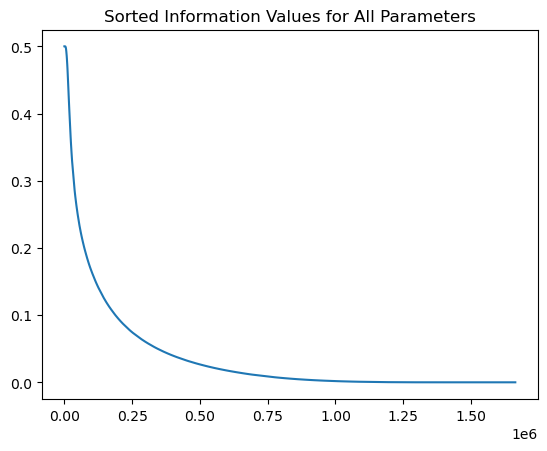

In [162]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))[::-1]

s_infolayers = [np.sort(p.cpu().flatten())[::-1] for p in info_true]

plt.plot(s_infocat)
plt.title('Sorted Information Values for All Parameters')
plt.show()

# from kneed import KneeLocator
# start = [0, 0, 0, 0, 0, 0, 0, 0]
# end = [-1, -1, -10000, -30, -1, -1, -1, -1]
# step = [1, 1, 1, 1, 100, 1, 1, 1]
# auto_thresholds = []
# for i in range(len(s_infolayers)):
#     kneedle = KneeLocator(range(len(s_infolayers[i][start[i]:end[i]:step[i]])), s_infolayers[i][start[i]:end[i]:step[i]], curve='convex', direction='decreasing', online=True)
#     auto_thresholds.append(start[i]+kneedle.knee*step[i])
#     print(f'Layer {i} knee:', auto_thresholds[i])

auto_percentage = 8
custom_percentages = [None, None, None, None, None, None, None, None]

percentages = [auto_percentage if custom_percentages[i] is None else custom_percentages[i] for i in range(len(custom_percentages))]

auto_thresholds = [len(s_infolayers[i]) // 100 * percentages[i] for i in range(len(s_infolayers))]

custom_thresholds = [None, None, None, None, None, None, None, None]

thresholds = [auto_thresholds[i] if custom_thresholds[i] is None else custom_thresholds[i] for i in range(len(custom_thresholds))]

# for i in range(len(s_infolayers)):
#     fig, axs = plt.subplots(1, 1, figsize=(14, 5))
#     axs.plot(s_infolayers[i])
#     axs.axvline(auto_thresholds[i], color='red', linestyle='--', label='Auto threshold')
#     axs.axvline(thresholds[i], color='green', linestyle='--', label='Custom threshold')
#     axs.legend()
#     axs.set_title(f'Thresholds for layer {i}')
#     fig.show()

    


Parameters reset unlearning

In [163]:
thresholds_values = [p[thresholds[i]] for i,p in enumerate(s_infolayers)]
retrain_param_indices = []
for i, p in enumerate(info_true):
    if custom_thresholds[i] != 0:
        indices = torch.argwhere(p > thresholds_values[i])
        retrain_param_indices.append(indices)
    else:
        retrain_param_indices.append(torch.empty(size=[0 for _ in range(p.dim())]))

model_reset = copy.deepcopy(saved_model).cpu()
model_null = FLNet2()

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    #new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    new_p[tuple(retrain_param_indices[i].t())] = 0
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)

print("Accuracy before resetting:")
compute_accuracy_per_client(saved_model, trainloader_class_list)
print("Accuracy after resetting:")
compute_accuracy_per_client(model_reset, trainloader_class_list)



Accuracy before resetting:
Accuracy for class 0: 100.00%
Accuracy for class 1: 100.00%
Accuracy for class 2: 100.00%
Accuracy for class 3: 99.98%
Accuracy for class 4: 99.95%
Accuracy for class 5: 97.16%
Accuracy for class 6: 98.94%
Accuracy for class 7: 98.52%
Accuracy for class 8: 95.97%
Accuracy for class 9: 96.22%
Accuracy after resetting:
Accuracy for class 0: 99.78%
Accuracy for class 1: 99.58%
Accuracy for class 2: 99.80%
Accuracy for class 3: 99.95%
Accuracy for class 4: 97.64%
Accuracy for class 5: 91.96%
Accuracy for class 6: 98.38%
Accuracy for class 7: 98.36%
Accuracy for class 8: 92.84%
Accuracy for class 9: 0.00%


In [164]:
print("Confusion matrix before resetting:")
acc, conf_mat = validate(saved_model, trainloader_class_list, 10, device)
plot_confusion_matrix(conf_mat)
print("Confusion matrix after resetting:")
acc, conf_mat = validate(model_reset, trainloader_class_list, 10, device)
plot_confusion_matrix(conf_mat)

Confusion matrix before resetting:


KeyboardInterrupt: 

In [ ]:
def print_info_stats(information):
    """
    Compute statistics for the information values.
    """
    # Flatten the information values and convert to numpy
    layers_total_information = [torch.sum(p) for p in information]

    for i, info in enumerate(layers_total_information):
        print(f"Layer {i} - Total Information: {info:.4f}")
    
    print(f"Total Information: {sum(layers_total_information):.4f}")

print("Information before resetting:")
print_info_stats(info_true)

reset_info_true = copy.deepcopy(info_true)
for i in range(len(reset_info_true)):
    reset_info_true[i][tuple(retrain_param_indices[i].t())] = 0
print("Information after resetting:")
print_info_stats(reset_info_true)

Information before resetting:
Layer 0 - Total Information: 27.7962
Layer 1 - Total Information: 1.4031
Layer 2 - Total Information: 1987.1033
Layer 3 - Total Information: 2.3684
Layer 4 - Total Information: 59712.2422
Layer 5 - Total Information: 20.1127
Layer 6 - Total Information: 258.7061
Layer 7 - Total Information: 0.4842
Total Information: 62010.2188
Information after resetting:
Layer 0 - Total Information: 20.3885
Layer 1 - Total Information: 1.4031
Layer 2 - Total Information: 1366.3354
Layer 3 - Total Information: 2.3684
Layer 4 - Total Information: 19738.1660
Layer 5 - Total Information: 11.2264
Layer 6 - Total Information: 88.9422
Layer 7 - Total Information: 0.4842
Total Information: 21229.3145


In [ ]:
class UnlearnNet(nn.Module):
    """
    A module that wraps an existing model and selectively retrains individual 
    scalar elements (indices) of its parameters while keeping the rest fixed.
    """

    def __init__(self, base_model, indices_to_retrain):
        """
        Args:
            base_model (nn.Module): The original model whose parameters 
                                    we want to partially retrain.
            indices_to_retrain (List[torch.Tensor]): For each parameter of 
                                    'base_model', a tensor of indices indicating 
                                    which scalar values should be retrained.
        """
        super().__init__()

        # We store the base model inside a dictionary to allow
        # functional calls later without overshadowing state_dict keys.
        self.inner_model = {"model": base_model}

        # Move any index tensors to CPU and store them.
        self.indices_to_retrain = [idx.cpu() for idx in indices_to_retrain]

        # Create a copy of the base model's parameters as buffers, where
        # we zero out the positions that will be retrained.
        base_params = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            # Detach a clone of the original parameter
            cloned_param = param.clone().detach()
            # Zero-out the entries we plan to retrain
            if len(self.indices_to_retrain[i]) > 0:
                cloned_param[tuple(self.indices_to_retrain[i].t())] = 0
            base_params[param_name] = cloned_param

        # Register these base parameters as buffers so they are not optimized
        for param_name, buf in base_params.items():
            buf_name = param_name.replace(".", "_")
            self.register_buffer(f"base_{buf_name}", buf)

        # Create the new learnable parameters for only the chosen indices
        retrain_params_dict = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # We create a 1D tensor (one entry per retrained element)
            key = param_name.replace(".", "_")
            retrain_params_dict[key] = nn.Parameter(
                torch.zeros(len(self.indices_to_retrain[i]))
            )
        self.retrain_params = nn.ParameterDict(retrain_params_dict)

        # Build sparse masks to apply the learnable values at the correct indices
        sparse_masks = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # 'retrain_indices' has shape (k, n_dims). Add a final dim to index positions in the retrain-param vector.
            retrain_indices = indices_to_retrain[i]
            k = retrain_indices.size(0)

            # Create an index column [0..k-1], then concatenate it with 'retrain_indices'.
            row_idx = torch.arange(k).unsqueeze(1)
            final_idx_matrix = torch.cat([retrain_indices, row_idx], dim=1)

            # A sparse_coo_tensor expects indices with shape (ndim, nnz). Transpose to (n_dims+1, k).
            indices_for_sparse = final_idx_matrix.t().contiguous()

            # Append k as the final dimension so each retrained element indexes differently.
            mask_shape = tuple(param.size()) + (k,)

            # Build the sparse mask with 1.0 at the retrained indices.
            key = f"mask_{param_name.replace('.', '_')}"
            sparse_masks[key] = torch.sparse_coo_tensor(
                indices_for_sparse,
                torch.ones(k, dtype=torch.float32),
                size=mask_shape
            )
        
        # Register these sparse masks as buffers
        for mask_name, mask in sparse_masks.items():
            self.register_buffer(mask_name, mask.coalesce())

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        This effectively applies elementwise multiplication with 'vec'
        across the last dimension of 'sp_tensor'.
        """

        # Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values = sp_tensor.values()

        # Multiply each sparse value by the corresponding element in 'vec'
        # indices[-1] indicates which element in 'vec' to use per sparse entry
        new_values = values * vec[indices[-1]]

        # Create a new sparse_coo_tensor with one fewer dimension
        new_shape = sp_tensor.shape[:-1]
        new_indices = indices[:-1, :]  # drop the last dimension index row

        result_tensor = torch.sparse_coo_tensor(
            new_indices,
            new_values,
            size=new_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        return result_tensor

    def forward(self, x):
        """
        Forward pass using a functional call to the base model. We reconstruct 
        final parameters by adding the base buffers and the contracted retrain 
        parameters at the relevant indices.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )

        # Perform a functional forward pass with the reconstructed parameters
        return torch.func.functional_call(model, final_params, x)
    
    def get_retrained_params(self):
        """
        Returns the retrained parameters of the model.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )
        
        detached_params = {}
        for key, value in final_params.items():
            detached_params[key] = value.cpu().detach()
        return detached_params
    

In [ ]:
assert RETRAIN
#Test
unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

print("Unlearn model parameters:")
for name , param in unlearn_model.named_parameters():
    print(name, param.shape)

# print("Accuracy (reset before retrain)")
# compute_accuracy_per_client(unlearn_model, trainloader_class_list)


Unlearn model parameters:
retrain_params.0_weight torch.Size([96])
retrain_params.3_weight torch.Size([6144])
retrain_params.7_bias torch.Size([60])
retrain_params.7_weight torch.Size([192672])
retrain_params.9_weight torch.Size([612])


In [ ]:
num_of_repeats = 1
num_fl_rounds = 1

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
parties = list(range(5))
del parties[party_to_be_erased]

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=len(parties), fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in parties:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    #print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    #print(f"Gradient is None for {name}")
                    pass
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

Training party 0
Training party 1
Training party 2


KeyboardInterrupt: 

In [ ]:
print("Accuracy after retrain")
compute_accuracy_per_client(eval_model, trainloader_class_list)


Accuracy after retrain
Accuracy for class 0: 87.02%
Accuracy for class 1: 97.82%
Accuracy for class 2: 75.21%
Accuracy for class 3: 48.83%
Accuracy for class 4: 88.29%
Accuracy for class 5: 0.00%
Accuracy for class 6: 0.00%
Accuracy for class 7: 0.00%
Accuracy for class 8: 0.00%
Accuracy for class 9: 0.00%


In [ ]:
print("Confusion matrix after retrain:")
acc, conf_mat = validate(eval_model, trainloader_class_list, 10, "cuda")
plot_confusion_matrix(conf_mat)

Confusion matrix after retrain:


KeyboardInterrupt: 

In [ ]:
trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 


final_model = FLNet2()
unlearned_params = eval_model.get_retrained_params()


final_model.load_state_dict(unlearned_params)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.01

# Create weights list
weights_unlearned = [1] * len(trainloader_list)
weights_unlearned[party_to_be_erased] = 0
weights_delta = weights_unlearned.copy()
weights_delta[party_to_be_erased] = delta

weights_unlearned=torch.tensor(weights_unlearned, dtype=torch.float32)
weights_delta=torch.tensor(weights_delta, dtype=torch.float32)

accumulated_diag_h_retrain = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_unlearned)
accumulated_diag_h_removed_retrain = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_delta)


NameError: name 'calculate_accumulated_diag_hessian' is not defined

0.weight
Number of degenaracies: 0
0.bias
Number of degenaracies: 0
3.weight
Number of degenaracies: 0
3.bias
Number of degenaracies: 0
7.weight
Number of degenaracies: 75849
7.bias
Number of degenaracies: 11
9.weight
Number of degenaracies: 110
9.bias
Number of degenaracies: 0
1541347
Number of outliers: 30827


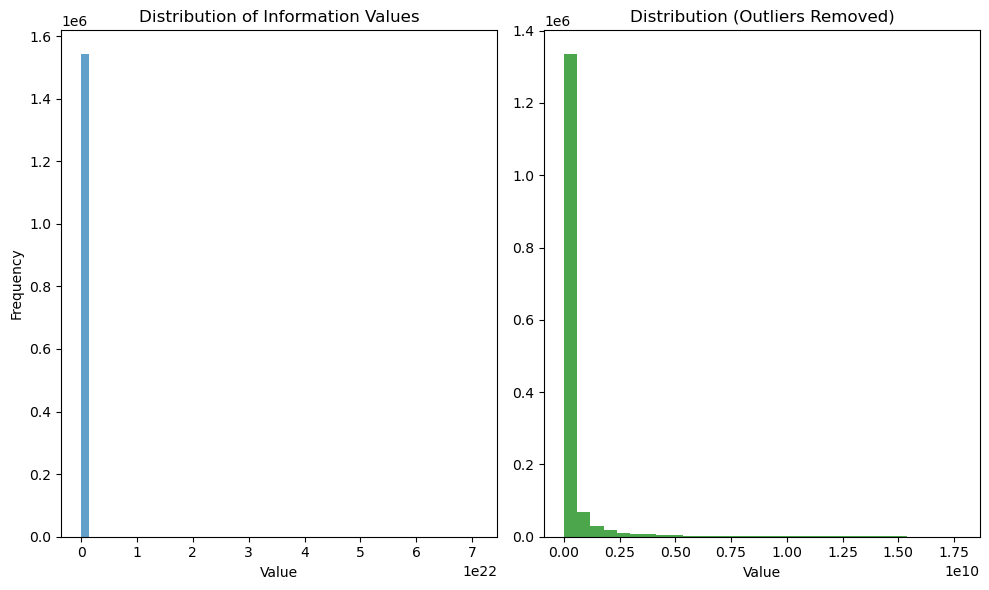

Sum of all information values: 76330996673945016467456.000000
Mean: 4.95222657080361e+16
Min: 7.105427357601002e-11
Max: 7.096975855513585e+22
Total number of values: 1541347
Sum of all information values: 612031161958400.000000
Mean: 405179104.0
Min: 7.105427357601002e-11
Max: 17778028544.0
Total number of values: 1510520


(7.633099667394502e+22, 612031161958400.0)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
info_true = compute_true_info(accumulated_diag_h_retrain, accumulated_diag_h_removed_retrain, torch.as_tensor([delta]).to(device))

plot_information(info_true)

In [ ]:
client0 = torch.load("client0")
client1 = torch.load("client1")
client2 = torch.load("client2")
client3 = torch.load("client3")
client4 = torch.load("client4")

# For NumPy arrays
import numpy as np

def count_equal_arrays(list1, list2):
    equal_count = 0
    min_length = min(len(list1), len(list2))
    
    for i in range(min_length):
        if np.array_equal(list1[i], list2[i]):
            print(list1[i])
            equal_count += 1
    
    return equal_count

count_equal_arrays(client4[6], client4[6])

import torch
import numpy as np

def tensor_list_distance(list1, list2, metric='euclidean'):
    """
    Compute various distance metrics between two lists of tensors.
    
    Args:
        list1: First list of tensors
        list2: Second list of tensors
        metric: Distance metric to use ('euclidean', 'manhattan', 'cosine', 'mean_squared', 'element_diff')
        
    Returns:
        float: The computed distance between the two tensor lists
    """
    # Make sure we only compare up to the length of the shorter list
    min_length = min(len(list1), len(list2))
    
    if min_length == 0:
        raise ValueError("At least one of the lists is empty")
        
    # Initialize distance
    distances = []
    
    # Compute distance for each pair of tensors
    for i in range(min_length):
        tensor1 = list1[i].float()  # Ensure tensors are float type
        tensor2 = list2[i].float()
        
        if metric == 'euclidean':
            # Euclidean distance
            dist = torch.sqrt(torch.sum((tensor1 - tensor2) ** 2)).item()
            distances.append(dist)
            
        elif metric == 'manhattan':
            # Manhattan (L1) distance
            dist = torch.sum(torch.abs(tensor1 - tensor2)).item()
            distances.append(dist)
            
        elif metric == 'cosine':
            # Cosine distance (1 - cosine similarity)
            dot_product = torch.sum(tensor1 * tensor2)
            norm1 = torch.sqrt(torch.sum(tensor1 ** 2))
            norm2 = torch.sqrt(torch.sum(tensor2 ** 2))
            
            # Avoid division by zero
            if norm1 == 0 or norm2 == 0:
                dist = 1.0  # Maximum distance
            else:
                cosine_sim = dot_product / (norm1 * norm2)
                # Clip to handle floating point errors
                cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
                dist = 1.0 - cosine_sim.item()
                
            distances.append(dist)
            
        elif metric == 'mean_squared':
            # Mean squared error
            dist = torch.mean((tensor1 - tensor2) ** 2).item()
            distances.append(dist)
            
        elif metric == 'element_diff':
            # Count of different elements
            diff_count = torch.sum(tensor1 != tensor2).item()
            distances.append(diff_count)
            
        else:
            raise ValueError(f"Unknown distance metric: {metric}")
    
    # Compute average distance across all tensor pairs
    avg_distance = np.mean(distances)
    
    # Calculate additional statistics
    stats = {
        "mean": avg_distance,
        "median": np.median(distances),
        "min": np.min(distances),
        "max": np.max(distances),
        "std": np.std(distances),
        "distances": distances  # List of all pairwise distances
    }
    
    return stats

    
# Compute distances using different metrics
for metric in ['euclidean', 'element_diff']:
    result = tensor_list_distance(client0[4], client1[4], metric=metric)
    print(f"\n{metric.upper()} Distance:")
    print(f"Mean: {result['mean']:.6f}")
    print(f"Median: {result['median']:.6f}")
    print(f"Min: {result['min']:.6f}")
    print(f"Max: {result['max']:.6f}")
    print(f"Std: {result['std']:.6f}")


FileNotFoundError: [Errno 2] No such file or directory: 'client0'